## Story - 6 : What Is The State of Food Security and Nutrition in the US

#### Instructions
The United Nations Food and Agriculture Organization publication, The State of Food Security and Nutrition in the World 2022 (https://www.fao.org/documents/card/en/c/cc0639en) might lead one to the conclusion that it's an elsewhere problem. That the people who are suffering malnutrition and starvation are "elsewhere", not in our backyard. For this assignment you will need to take a closer look here at home (the US)

#### Notes:
- You will need to locate and source data that reflects food security and nutrition by state broken down by men, women, children and by age groups
- Your analysis should demonstrate correlations that exist between level of poverty and food insecurity, malnutrition and starvation.
- Your data and analysis should also indicate what happens to the children as they mature into adults. Will they become fully functional citizens or will they require continued support?
- You data visualizations need to tell the story for a political audience that you were lobbying to address the issue of food insecurity in the US
- This assignment is due at the end of the week twelve of the semester.

In [1]:
import io
import zipfile
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np

C:\Users\johnf\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#ERS Food Security Data
ERS_ZIP_URL = "https://www.ers.usda.gov/media/799/food-security-csv-data-files.zip"

resp = requests.get(ERS_ZIP_URL)
resp.raise_for_status()

zip_bytes = io.BytesIO(resp.content)

with zipfile.ZipFile(zip_bytes) as z:
    csv_files = [name for name in z.namelist() if name.lower().endswith(".csv")]
    print("Files in ERS archive:")
    for name in csv_files:
        print("  ", name)

    # State Level Data 
    state_like = [name for name in csv_files if "state" in name.lower()]
    if not state_like:
        raise RuntimeError(
            "Could not auto-detect a 'state' CSV. " )
    state_csv = state_like[0]
    print("\nUsing state-level file:", state_csv)

    with z.open(state_csv) as f:
        state_df = pd.read_csv(f, encoding="cp1252")

    # Mostly National All households data 
    all_hh_like = [name for name in csv_files if "all_households" in name.lower()]
    if not all_hh_like:
        raise RuntimeError("Could not auto-detect an 'all households' CSV. ")
    all_hh_csv = all_hh_like[0]
    print("Using all-households file:", all_hh_csv)

    with z.open(all_hh_csv) as f:
        all_households_df = pd.read_csv(f, encoding="cp1252")

Files in ERS archive:
   foodsecurity_csv_datafiles/foodsecurity_all_households_2023.csv
   foodsecurity_csv_datafiles/foodsecurity_child_trends_2023.csv
   foodsecurity_csv_datafiles/foodsecurity_educ_emp_dis_2023.csv
   foodsecurity_csv_datafiles/foodsecurity_hh_w_children_2023.csv
   foodsecurity_csv_datafiles/foodsecurity_readme_2023.csv
   foodsecurity_csv_datafiles/foodsecurity_state_2023.csv

Using state-level file: foodsecurity_csv_datafiles/foodsecurity_state_2023.csv
Using all-households file: foodsecurity_csv_datafiles/foodsecurity_all_households_2023.csv


In [3]:
## From the state level, they are 3 year data points. Taking the 2021 - 2023 points in orderto have more recetn State by State info
## only keeping the Food Insecurity Prevalents percetn info

## Minimalist Latest for state level 
latest_state_df = state_df[["State","Food insecurity prevalence","Very low food security prevalence"]][state_df['Year']=='2021–2023']
latest_state_df['year'] = 2023
latest_state_df = latest_state_df.rename(columns={"State":"state",
                                                  "Food insecurity prevalence":"food_insecure_pct__21_23",
                                                  "Very low food security prevalence":"very_food_insecure_pct_21_23"})

## Over Time State Level Simple - Only Food Insecure Not any other categories
latest = state_df[["Year","State","Food insecurity prevalence"]][state_df["Year"]=='2021–2023']
latest = latest.rename(columns={"Year":"year","State":"state","Food insecurity prevalence":"food_insecure_21_23"})
latest = latest.drop(columns=['year'])
earliest = state_df[["Year","State","Food insecurity prevalence"]][state_df["Year"]=="2006–2008"]
earliest = earliest.rename(columns={"Year":"year","State":"state","Food insecurity prevalence":"food_insecure_06_08"})
earliest = earliest.drop(columns=['year'])

## Merging
state_level_change = latest.merge(earliest,on=['state'])
state_level_change['food_insecure_change_0608_2123'] = state_level_change["food_insecure_21_23"] - state_level_change["food_insecure_06_08"]

## Rmoeving Country Level
state_level_change = state_level_change[state_level_change['state']!='U.S.']
state_level_change_0608_2123_final = state_level_change[["state","food_insecure_change_0608_2123"]].sort_values(by=["food_insecure_change_0608_2123"],ascending=False)
state_level_change_0608_2123_final

## Putting togethert 
state_level_snapshot = latest_state_df.merge(state_level_change_0608_2123_final, on =['state']).drop(columns=["year"])
# state_level_snapshot

In [4]:
## All households over time 
nation_yearly_food_insec = all_households_df[["Year","Food insecure-percent","Low food security-percent","Very low food security-percent"
                  ]][((all_households_df["Category"]=="All households")
                   &(all_households_df["Subcategory"].isnull()))]
nation_yearly_food_insec['Year'] =nation_yearly_food_insec['Year'].astype(int)
nation_yearly_food_insec = nation_yearly_food_insec.rename(columns={"Year":"year",
                                                                    "Food insecure-percent":"food_insecure_pct",
                                                                    "Low food security-percent":"low_food_security_pct",
                                                                    "Very low food security-percent":"very_low_food_security_pct"
                                                                   })
# print(nation_yearly_food_insec.head())

## Regional Insec Over Time 
regional_overtime = all_households_df[["Year","Subcategory","Food insecure-percent","Low food security-percent",
                                       "Very low food security-percent"]][all_households_df["Category"]=="Census geographic region"]
regional_overtime['Year'] =regional_overtime['Year'].astype(int)
regional_overtime = regional_overtime.rename(columns={"Year":"year","Subcategory":"region",
                                                                    "Food insecure-percent":"food_insecure_pct",
                                                                    "Low food security-percent":"low_food_security_pct",
                                                                    "Very low food security-percent":"very_low_food_security_pct"
                                                                   })
# print('----')
# print(regional_overtime.head())

In [5]:
ne_reg = regional_overtime[['year',"food_insecure_pct"]][regional_overtime["region"]=="Northeast"].rename(columns={"food_insecure_pct":"northeast_food_insecure_pct"})
mw_reg = regional_overtime[['year',"food_insecure_pct"]][regional_overtime["region"]=="Midwest"].rename(columns={"food_insecure_pct":"midwest_food_insecure_pct"})
so_reg = regional_overtime[['year',"food_insecure_pct"]][regional_overtime["region"]=="South"].rename(columns={"food_insecure_pct":"south_food_insecure_pct"})
we_reg = regional_overtime[['year',"food_insecure_pct"]][regional_overtime["region"]=="West"].rename(columns={"food_insecure_pct":"west_food_insecure_pct"})
regions = ne_reg.merge(mw_reg,on='year').merge(so_reg,on='year').merge(we_reg,on='year')
# regions.head()

In [6]:
elderly_children_overtime = all_households_df[["Year","Category","Subcategory","Total",
                                               "Food insecure-percent","Low food security-percent",
                                               "Very low food security-percent"]][(
    (all_households_df["Category"]=='Household composition')
    &((all_households_df["Subcategory"].isin(["With elderly"])
                                                            &all_households_df["Sub-subcategory"].isnull()))
                     |(all_households_df["Subcategory"].isin(["With children < 18 years"])
                       &(all_households_df["Sub-subcategory"].isnull())))]
children = elderly_children_overtime[elderly_children_overtime["Subcategory"]=="With children < 18 years"]
children = children.rename(columns={"Year":"year",
                         "Food insecure-percent":"hh_w_und_18_food_insec_pct"})
elderly = elderly_children_overtime[elderly_children_overtime["Subcategory"]=="With elderly"]
elderly = elderly.rename(columns={"Year":"year",
                         "Food insecure-percent":"hh_w_elder_food_insec_pct"})
child_eld = children[["year","hh_w_und_18_food_insec_pct"]].merge(elderly[["year","hh_w_elder_food_insec_pct"]], on=["year"])
nation_yearly_food_insec = nation_yearly_food_insec[["year","food_insecure_pct"]].rename(columns={"food_insecure_pct":"national_food_insecure_pct"})
national_overtime_snapshot = child_eld.merge(nation_yearly_food_insec,on=['year'])
national_overtime_snapshot['year']=national_overtime_snapshot['year'].astype(int)


nochild_women_men = all_households_df[
    (all_households_df["Category"] == "Household composition") &
    (all_households_df["Subcategory"] == "With no children < 18 years") &
    (all_households_df["Sub-subcategory"].isin(["Women living alone", "Men living alone"]))
][["Year", "Sub-subcategory", "Food insecure-percent"]].copy()

# Clean column names
nochild_women = nochild_women_men[["Year","Food insecure-percent"]][nochild_women_men["Sub-subcategory"]=="Women living alone"].rename(columns={"Year": "year","Food insecure-percent": "women_no_child_food_insec_pct" })
nochild_men = nochild_women_men[["Year","Food insecure-percent"]][nochild_women_men["Sub-subcategory"]=="Men living alone"].rename(columns={"Year": "year","Food insecure-percent": "men_no_child_food_insec_pct" })


# Merge into your national_overtime_snapshot
national_overtime_snapshot = national_overtime_snapshot.merge(nochild_women,on="year").merge(nochild_men,on="year")

# (keep your existing line – just after the merge above)
national_overtime_snapshot["year"] = national_overtime_snapshot["year"].astype(int)

# --------- existing code: merge with regions ----------
overtime_all = national_overtime_snapshot.merge(regions, on="year")

In [7]:
# overtime_all

In [8]:
### Need state name to abrv df 
states_data = {
    "state": [        "Alabama",
        "Alaska",
        "Arizona",
        "Arkansas",
        "California",
        "Colorado",
        "Connecticut",
        "Delaware",
        "District of Columbia",
        "Florida",
        "Georgia",
        "Hawaii",
        "Idaho",
        "Illinois",
        "Indiana",
        "Iowa",
        "Kansas",
        "Kentucky",
        "Louisiana",
        "Maine",
        "Maryland",
        "Massachusetts",
        "Michigan",
        "Minnesota",
        "Mississippi",
        "Missouri",
        "Montana",
        "Nebraska",
        "Nevada",
        "New Hampshire",
        "New Jersey",
        "New Mexico",
        "New York",
        "North Carolina",
        "North Dakota",
        "Ohio",
        "Oklahoma",
        "Oregon",
        "Pennsylvania",
        "Rhode Island",
        "South Carolina",
        "South Dakota",
        "Tennessee",
        "Texas",
        "Utah",
        "Vermont",
        "Virginia",
        "Washington",
        "West Virginia",
        "Wisconsin",
        "Wyoming",
    ],
    "state_abbrev": [
        "AL",
        "AK",
        "AZ",
        "AR",
        "CA",
        "CO",
        "CT",
        "DE",
        "DC",
        "FL",
        "GA",
        "HI",
        "ID",
        "IL",
        "IN",
        "IA",
        "KS",
        "KY",
        "LA",
        "ME",
        "MD",
        "MA",
        "MI",
        "MN",
        "MS",
        "MO",
        "MT",
        "NE",
        "NV",
        "NH",
        "NJ",
        "NM",
        "NY",
        "NC",
        "ND",
        "OH",
        "OK",
        "OR",
        "PA",
        "RI",
        "SC",
        "SD",
        "TN",
        "TX",
        "UT",
        "VT",
        "VA",
        "WA",
        "WV",
        "WI",
        "WY",
    ],
}
states_abbrev_df = pd.DataFrame(states_data)

In [9]:
### Enriching the processed State dfs
state_level_change_0608_2123_final = state_level_change_0608_2123_final.rename(columns={"state":"state_abbrev"})
state_level_change_0608_2123_final =state_level_change_0608_2123_final.merge(states_abbrev_df,on=["state_abbrev"])
state_level_change_0608_2123_final = state_level_change_0608_2123_final.rename(columns={"food_insecure_change":"food_insecure_change_08_23"})

latest_state_df = latest_state_df[latest_state_df['state']!='U.S.'].rename(columns={"state":"state_abbrev"})
latest_state_df = latest_state_df.merge(states_abbrev_df,on=["state_abbrev"])

In [10]:
# --------- 1. Poverty by state (ACS 2023 1-year, subject table S1701) ---------
ACS_SUBJECT_URL = "https://api.census.gov/data/2023/acs/acs1/subject"

# S1701_C03_001E = Percent of population below poverty level (all persons)
poverty_params = {"get": "NAME,S1701_C03_001E","for": "state:*",}
poverty_resp = requests.get(ACS_SUBJECT_URL, params=poverty_params)
poverty_resp.raise_for_status()
poverty_data = poverty_resp.json()

poverty_cols = poverty_data[0]
poverty_rows = poverty_data[1:]

poverty_df = pd.DataFrame(poverty_rows, columns=poverty_cols)

# Convert to numeric and clean column names
poverty_df["S1701_C03_001E"] = pd.to_numeric(
    poverty_df["S1701_C03_001E"], errors="coerce"
)
poverty_df = poverty_df.rename(columns={
    "NAME": "state",
    "S1701_C03_001E": "poverty_rate_pct",
    "state": "state_fips",
})

poverty_df = poverty_df[["state", "state_fips", "poverty_rate_pct"]]

print("Poverty data (first 5 rows):")
print(poverty_df.head())

Poverty data (first 5 rows):
        state state_fips  poverty_rate_pct
0     Alabama         01              15.6
1      Alaska         02              10.4
2     Arizona         04              12.4
3    Arkansas         05              15.7
4  California         06              12.0


In [11]:
## merging the poverty df with the food insecurity to show correlation 
poverty_food_sec_states_2023 = latest_state_df.merge(poverty_df,on=['state'])
# poverty_food_sec_states_2023

In [12]:
# Use the detailed ACS 1-year dataset, not the subject dataset
ACS_DETAILED_URL = "https://api.census.gov/data/2023/acs/acs1"

# C22001_001E = Total households
# C22001_002E = Households that received Food Stamps/SNAP in the past 12 months
snap_params = {
    "get": "NAME,C22001_001E,C22001_002E",
    "for": "state:*",
}

snap_resp = requests.get(ACS_DETAILED_URL, params=snap_params)
snap_resp.raise_for_status()
snap_data = snap_resp.json()

snap_cols = snap_data[0]
snap_rows = snap_data[1:]

snap_df = pd.DataFrame(snap_rows, columns=snap_cols)
snap_df["C22001_001E"] = pd.to_numeric(snap_df["C22001_001E"], errors="coerce")
snap_df["C22001_002E"] = pd.to_numeric(snap_df["C22001_002E"], errors="coerce")

# Compute percent of households receiving SNAP
snap_df["snap_households_pct"] = (snap_df["C22001_002E"] / snap_df["C22001_001E"] * 100)
snap_df = snap_df.rename(columns={"NAME": "state",
                                  "C22001_001E": "households_total",
                                  "C22001_002E": "households_snap",
                                  "state": "state_fips",
                                  })
snap_df = snap_df[["state", "state_fips", "households_total",
                   "households_snap", "snap_households_pct"]]



In [13]:
#Pulling in the Other State-level data 2023
state_level_2023 = snap_df.merge(poverty_food_sec_states_2023, on=['state','state_fips']).rename(columns={"food_insecure_pct__21_23":"food_insecure_pct"})
state_level_2023 = state_level_2023[["state","households_total","households_snap","snap_households_pct","food_insecure_pct","poverty_rate_pct"]]
# state_level_2023

### ---------------------------

### Visualization 1 - The current State of Food Insecurity (Breakdown of Demographics Impacted)

In [14]:
overtime_all

,year,hh_w_und_18_food_insec_pct,hh_w_elder_food_insec_pct,national_food_insecure_pct,women_no_child_food_insec_pct,men_no_child_food_insec_pct,northeast_food_insecure_pct,midwest_food_insecure_pct,south_food_insecure_pct,west_food_insecure_pct
0,2001,16.1,5.5,10.7,9.7,10.4,8.2,9.0,12.3,11.9
1,2002,16.5,6.3,11.1,10.5,11.2,9.2,9.6,12.4,12.1
2,2003,16.7,6.0,11.2,10.1,10.9,9.6,9.9,12.4,12.1
3,2004,17.6,6.5,11.9,11.8,12.3,9.7,10.9,13.3,12.8
4,2005,15.6,6.0,11.0,11.0,11.5,9.1,11.1,12.0,10.8
5,2006,15.6,6.0,10.9,11.3,11.4,9.2,10.7,12.3,10.5
6,2007,15.8,6.5,11.1,11.7,11.2,10.3,10.7,11.8,11.0
7,2008,21.0,8.1,14.6,14.9,14.0,12.8,14.0,15.9,14.5
8,2009,21.3,7.5,14.7,14.7,14.5,12.2,13.9,15.9,15.5
9,2010,20.2,7.9,14.5,13.7,15.0,12.4,13.3,16.0,15.1


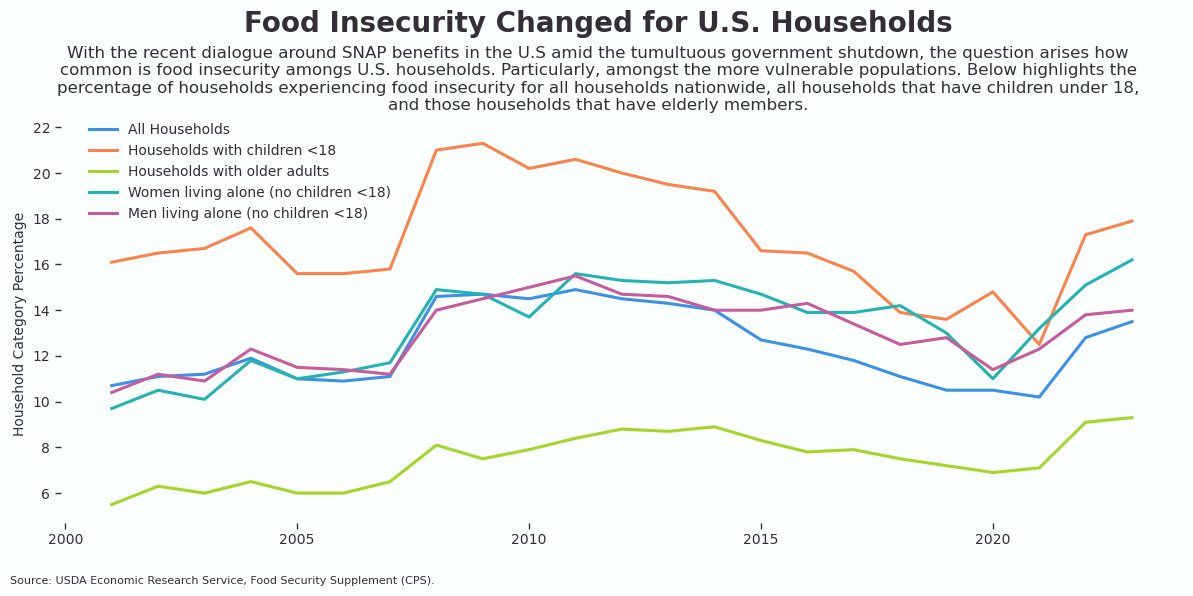

In [15]:
snap_df = overtime_all[[
    "year",
    "hh_w_und_18_food_insec_pct",
    "hh_w_elder_food_insec_pct",
    "national_food_insecure_pct",
    "women_no_child_food_insec_pct",
    "men_no_child_food_insec_pct"
]].copy()

snap_df["year"] = pd.to_numeric(snap_df["year"], errors="coerce")
snap_df = snap_df.sort_values("year")

# ---- custom colors ----
color_all = "#3C91E6"      # Bright Ocean
color_children = "#FA824C" # Coral Glow
color_elder = "#A2D729"    # Yellow Green
bg_color = "#FAFFFD"       # Porcelain
text_grey = "#342E37"      # Shadow Grey
color_women    = "#24B3B3"  # Teal
color_men      = "#C95A9E" #Magenta
# ------------------------

fig, ax = plt.subplots(figsize=(12, 6))

fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

title_text = "Food Insecurity Changed for U.S. Households"
subtitle_text = (
    "With the recent dialogue around SNAP benefits in the U.S amid the tumultuous government shutdown, the question arises how\n"
    "common is food insecurity amongs U.S. households. Particularly, amongst the more vulnerable populations. Below highlights the\n"
    "percentage of households experiencing food insecurity for all households nationwide, all households that have children under 18,\n"
    "and those households that have elderly members."
)

# Title
fig.suptitle(
    title_text,
    fontsize=20,
    weight="bold",
    color=text_grey,
    x=0.5,
    y=0.98,
)

# Subtitle (slightly larger & a bit farther from title)
fig.text(
    0.5,
    0.92,       # moved down a bit for better spacing
    subtitle_text,
    ha="center",
    va="top",
    fontsize=12,  # larger
    color=text_grey,
)

# ----- Lines -----
ax.plot(
    snap_df["year"],
    snap_df["national_food_insecure_pct"],
    label="All Households",
    linewidth=2.2,
    color=color_all,
)

ax.plot(
    snap_df["year"],
    snap_df["hh_w_und_18_food_insec_pct"],
    label="Households with children <18",
    linewidth=2.2,
    color=color_children,
)

ax.plot(
    snap_df["year"],
    snap_df["hh_w_elder_food_insec_pct"],
    label="Households with older adults",
    linewidth=2.2,
    color=color_elder,
)
ax.plot(
    snap_df["year"],
    snap_df["women_no_child_food_insec_pct"],
    label="Women living alone (no children <18)",
    linewidth=2.2,
    color=color_women)

ax.plot(
    snap_df["year"],
    snap_df["men_no_child_food_insec_pct"],
    label="Men living alone (no children <18)",
    linewidth=2.2,
    color=color_men
)

# ----- Minimalist axes -----
ax.grid(False)
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis="both", length=4, width=1, colors=text_grey)

ax.set_xlabel("", color=text_grey)
ax.set_ylabel(
    "Household Category Percentage",
    color=text_grey,
)

# Y-axis as whole numbers only
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Legend
legend = ax.legend(
    frameon=False,
    loc="upper left",
    bbox_to_anchor=(0.02, 1.02),
    borderaxespad=0.0,
)
for text in legend.get_texts():
    text.set_color(text_grey)

# Source note
fig.text(
    0.01,
    0.02,
    "Source: USDA Economic Research Service, Food Security Supplement (CPS).",
    ha="left",
    va="bottom",
    fontsize=8,
    color=text_grey,
)

plt.tight_layout(rect=[0, 0.06, 1, 0.9])
plt.show()


### visualization 2 - State-Level Change from 08 to 23 

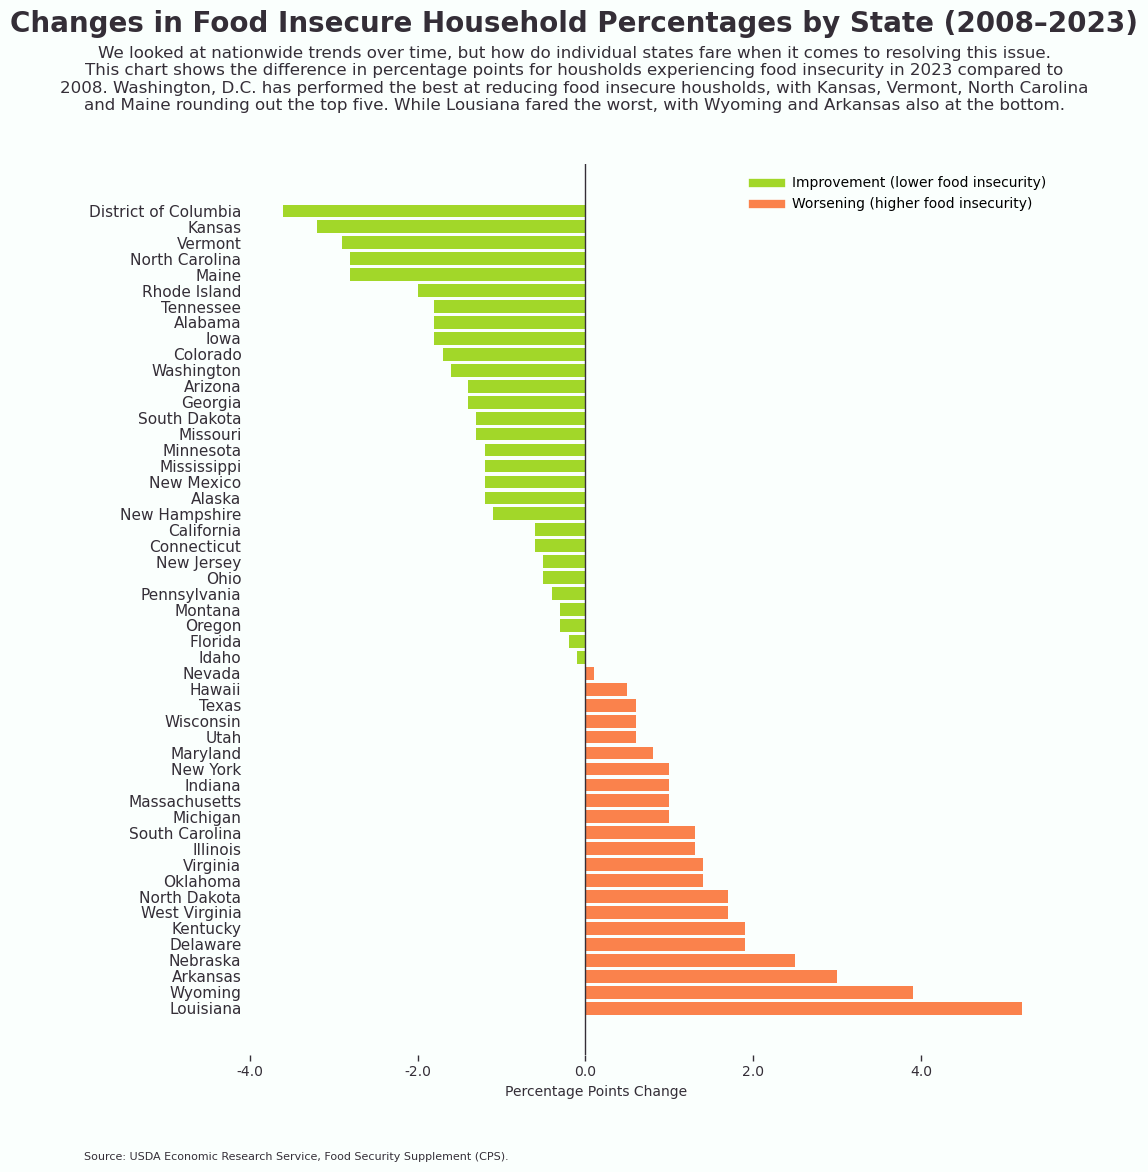

In [16]:
abbrev_to_name = dict(zip(states_abbrev_df["state_abbrev"], states_abbrev_df["state"]))
bar_df = state_level_snapshot[["state", "food_insecure_change_0608_2123"]].copy()
bar_df["state_full"] = bar_df["state"].map(abbrev_to_name)
bar_df = bar_df.sort_values("food_insecure_change_0608_2123", ascending=False)

def bar_color(x):
    return "#A2D729" if x < 0 else "#FA824C"  # Yellow Green / Coral Glow

bar_colors = [bar_color(x) for x in bar_df["food_insecure_change_0608_2123"]]

bg_color = "#FAFFFD"   # Porcelain
text_grey = "#342E37"  # Shadow Grey

fig, ax = plt.subplots(figsize=(10, 12))
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

title_text = "Changes in Food Insecure Household Percentages by State (2008–2023)"
subtitle_text = (
    "We looked at nationwide trends over time, but how do individual states fare when it comes to resolving this issue.\n"
    "This chart shows the difference in percentage points for housholds experiencing food insecurity in 2023 compared to\n"
    "2008. Washington, D.C. has performed the best at reducing food insecure housholds, with Kansas, Vermont, North Carolina\n"
    "and Maine rounding out the top five. While Lousiana fared the worst, with Wyoming and Arkansas also at the bottom."
)

# ---- TITLE
fig.suptitle(
    title_text,
    fontsize=20,      
    weight="bold",
    color=text_grey,
    x=0.5,
    y=0.98,         
)

# Subtitle 
fig.text(
    0.5,
    0.95,
    subtitle_text,
    ha="center",
    va="top",
    fontsize=12,
    color=text_grey,
)

# --- horizontal bar chart with full state names ---
ax.barh(
    bar_df["state_full"],
    bar_df["food_insecure_change_0608_2123"],
    color=bar_colors,
)

# zero reference line
ax.axvline(0, color=text_grey, linewidth=1)

# minimalist styling
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

ax.tick_params(
    axis="y",
    labelsize=11,
    length=0,
    colors=text_grey,
)
ax.tick_params(axis="x", length=4, width=1, colors=text_grey)

ax.set_xlabel(
    "Percentage Points Change",
    color=text_grey,
    x=0.43
)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

from matplotlib.lines import Line2D
legend_elems = [
    Line2D([0], [0], color="#A2D729", lw=6, label="Improvement (lower food insecurity)"),
    Line2D([0], [0], color="#FA824C", lw=6, label="Worsening (higher food insecurity)"),
]
ax.legend(handles=legend_elems, frameon=False, loc="upper right")

fig.text(
    0.01,
    0.02,
    "Source: USDA Economic Research Service, Food Security Supplement (CPS).",
    ha="left",
    va="bottom",
    fontsize=8,
    color=text_grey,
)

plt.tight_layout(rect=[0, 0.06, 1, 0.9])
plt.show()


### Visualization 3 SNAP Benefits and Food Security

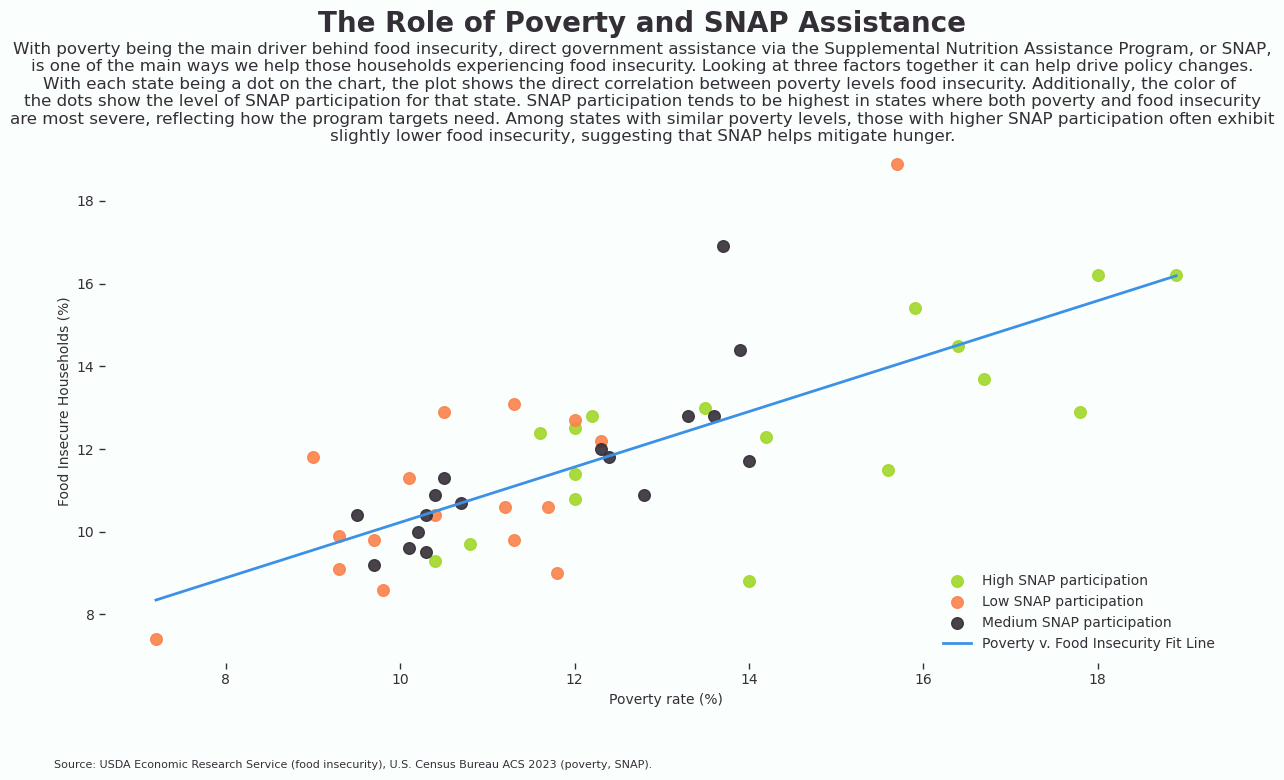

In [17]:
df = state_level_2023.copy()

# Categorize states by SNAP participation (low/med/high)
q1, q2 = df["snap_households_pct"].quantile([0.33, 0.66])

def snap_group(p):
    if p <= q1:
        return "Low SNAP participation"
    elif p <= q2:
        return "Medium SNAP participation"
    else:
        return "High SNAP participation"

df["snap_group"] = df["snap_households_pct"].apply(snap_group)

# New palette:
#   High SNAP      -> Green
#   Medium SNAP    -> Brownish grey
#   Low SNAP       -> Orange
snap_colors = {
    "High SNAP participation":   "#A2D729",  # green
    "Medium SNAP participation": "#342E37",  # brownish grey (Shadow Grey)
    "Low SNAP participation":    "#FA824C",  # Coral Glow / orange
}

df["color"] = df["snap_group"].map(snap_colors)

#  Fit a simple regression line (poverty -> food insecurity) -------
x = df["poverty_rate_pct"].values
y = df["food_insecure_pct"].values

m, b = np.polyfit(x, y, 1)  # slope, intercept
line_x = np.linspace(x.min(), x.max(), 100)
line_y = m * line_x + b
bg_color = "#FAFFFD"   
text_grey = "#342E37" 

fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)

title_text = "The Role of Poverty and SNAP Assistance"
subtitle_text = (
    "With poverty being the main driver behind food insecurity, direct government assistance via the Supplemental Nutrition Assistance Program, or SNAP,\n"
    "is one of the main ways we help those households experiencing food insecurity. Looking at three factors together it can help drive policy changes.\n"
    "With each state being a dot on the chart, the plot shows the direct correlation between poverty levels food insecurity. Additionally, the color of \n"
    "the dots show the level of SNAP participation for that state. SNAP participation tends to be highest in states where both poverty and food insecurity\n"
    "are most severe, reflecting how the program targets need. Among states with similar poverty levels, those with higher SNAP participation often exhibit\n"
    "slightly lower food insecurity, suggesting that SNAP helps mitigate hunger."
)

fig.suptitle(
    title_text,
    fontsize=20,
    weight="bold",
    color=text_grey,
    x=0.5,
    y=0.97,
)

# Nudge subtitle down just a bit for breathing room
fig.text(
    0.5,
    0.93,
    subtitle_text,
    ha="center",
    va="top",
    fontsize=12,
    color=text_grey,
)

# Scatter points
for group, sub in df.groupby("snap_group"):
    ax.scatter(
        sub["poverty_rate_pct"],
        sub["food_insecure_pct"],
        label=group,
        color=snap_colors[group],
        s=70,
        alpha=0.9,
    )

# Regression line (blue)
ax.plot(
    line_x,
    line_y,
    color="#3C91E6",   # Bright Ocean
    linewidth=2,
    label="Poverty v. Food Insecurity Fit Line",
)

# Minimalist styling
ax.grid(False)
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis="both", length=4, width=1, colors=text_grey)

ax.set_xlabel("Poverty rate (%)", color=text_grey)
ax.set_ylabel("Food Insecure Households (%)", color=text_grey)

ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Legend
legend = ax.legend(frameon=False, loc="lower right")
for text in legend.get_texts():
    text.set_color(text_grey)

# Source note
fig.text(
    0.01,
    0.02,
    "Source: USDA Economic Research Service (food insecurity), U.S. Census Bureau ACS 2023 (poverty, SNAP).",
    ha="left",
    va="bottom",
    fontsize=8,
    color=text_grey,
)

# A bit more margin at top & bottom for text and legend
plt.tight_layout(rect=[0, 0.08, 1, 0.88])
plt.show()


## ----------------SCRAP BELOW ----------------------

### Visualilzation 2 - Change Over Time by Region (Line Chart)

In [18]:
# import matplotlib.pyplot as plt
# from matplotlib.ticker import FormatStrFormatter

# # ----- Data prep -----
# region_df = overtime_all[[
#     "year",
#     "northeast_food_insecure_pct",
#     "midwest_food_insecure_pct",
#     "south_food_insecure_pct",
#     "west_food_insecure_pct",
# ]].copy()

# region_df["year"] = pd.to_numeric(region_df["year"], errors="coerce")
# region_df = region_df.sort_values("year")

# # ---- custom colors ----
# color_ne = "#3C91E6"      # Bright Ocean
# color_mw = "#FA824C"      # Coral Glow
# color_s  = "#A2D729"      # Yellow Green
# color_w  = "#342E37"      # Shadow Grey

# bg_color = "#FAFFFD"      # Porcelain
# text_grey = "#342E37"     # Shadow Grey
# # ------------------------

# fig, ax = plt.subplots(figsize=(12, 6))

# fig.patch.set_facecolor(bg_color)
# ax.set_facecolor(bg_color)

# title_text = "How Has Food Insecurity Changed Across U.S. Regions?"
# subtitle_text = (
#     "Share of households that are food insecure in each Census region, 2001–2023.\n"
#     "Each line shows the percent of households in that region that report food insecurity."
# )

# # Title
# fig.suptitle(
#     title_text,
#     fontsize=20,
#     weight="bold",
#     color=text_grey,
#     x=0.5,
#     y=0.97,
# )

# # Subtitle (slightly larger with extra spacing)
# fig.text(
#     0.5,
#     0.92,
#     subtitle_text,
#     ha="center",
#     va="top",
#     fontsize=12,
#     color=text_grey,
# )

# # ----- Lines -----
# ax.plot(
#     region_df["year"],
#     region_df["northeast_food_insecure_pct"],
#     label="Northeast",
#     linewidth=2.2,
#     color=color_ne,
# )

# ax.plot(
#     region_df["year"],
#     region_df["midwest_food_insecure_pct"],
#     label="Midwest",
#     linewidth=2.2,
#     color=color_mw,
# )

# ax.plot(
#     region_df["year"],
#     region_df["south_food_insecure_pct"],
#     label="South",
#     linewidth=2.2,
#     color=color_s,
# )

# ax.plot(
#     region_df["year"],
#     region_df["west_food_insecure_pct"],
#     label="West",
#     linewidth=2.2,
#     color=color_w,
# )

# # ----- Minimalist axes -----
# ax.grid(False)
# for spine in ["top", "right", "left", "bottom"]:
#     ax.spines[spine].set_visible(False)

# ax.tick_params(axis="both", length=4, width=1, colors=text_grey)

# ax.set_xlabel("Year", color=text_grey)
# ax.set_ylabel(
#     "Households experiencing food insecurity by region (%)",
#     color=text_grey,
# )

# # Y-axis as whole numbers only
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# # Legend
# legend = ax.legend(frameon=False, loc="upper left")
# for text in legend.get_texts():
#     text.set_color(text_grey)

# # Source note
# fig.text(
#     0.01,
#     0.02,
#     "Source: USDA Economic Research Service, Food Security Supplement (CPS).",
#     ha="left",
#     va="bottom",
#     fontsize=8,
#     color=text_grey,
# )

# plt.tight_layout(rect=[0, 0.06, 1, 0.9])
# plt.show()
